TEST - amelia


## Setup - test

In [33]:
%load_ext autoreload
%autoreload 2

import numpy as np
import numba as nb

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Consumption-Saving Model

In [1]:
# load local model file and initialize model class
from modelproject import DynHouseholdLaborModelClass
model = DynHouseholdLaborModelClass()

par = model.par
sol = model.sol
sim = model.sim

#test

In [35]:
model.solve()

/Users/bruger/Desktop/projects-2023-aca/modelproject/modelproject.py:247: RuntimeWarning: divide by zero encountered in double_scalars
  util_1 = ((Q/2))**(1.0-par.eta) / (1.0-par.eta) - rho1*(total1)**(1.0+par.gamma) / (1.0+par.gamma) + (par.norms-1)*par.rho_21*kids*(home1)**(1.0+par.gamma) / (1.0+par.gamma)
/Users/bruger/Desktop/projects-2023-aca/modelproject/modelproject.py:248: RuntimeWarning: divide by zero encountered in double_scalars
  util_2 = ((Q/2))**(1.0-par.eta) / (1.0-par.eta) - rho2*(total2)**(1.0+par.gamma) / (1.0+par.gamma) + par.rho_22*kids*(home2)**(1.0+par.gamma) / (1.0+par.gamma)


# Simulation

Now that we have a solution for all combinations of human capital grid points, we simulate `simN` synthetic individuals for `simT` periods. We do this by initializing all state-variables in the first period and simulate forwards. 

The state variables in our model include children and initial human capital of both member. We start by initilizing all households with no kids and both men and women with no human capital `sim.k1_init=np.zeros(par.simN)` and  `sim.k2_init=np.zeros(par.simN)`. <br>

We then loop forward using the solution:
$$
\begin{align*}
n_{i,t+1} &= n_{i,t} + b_{i,t}\\
l_{1,i,t} &= h_{1,t}^{\star}(k_{1,i,t},k_{2,i,t}) \\
h_{1,i,t} &= h_{2,t}^{\star}(k_{1,i,t},k_{2,i,t}) \\
l_{2,i,t} &= h_{1,t}^{\star}(k_{1,i,t},k_{2,i,t}) \\
h_{2,i,t} &= h_{2,t}^{\star}(k_{1,i,t},k_{2,i,t}) \\
k_{1,i,t+1} &= (1-\delta)k_{1,i,t} + l_{1,i,t}\\
k_{2,i,t+1} &= (1-\delta)k_{2,i,t} + l_{2,i,t}\\
y_{1,t+1} &= \alpha_{1,0}+\alpha_{1,1}k_{i,t}\\
y_{2,t+1} &= \alpha_{2,0}+\alpha_{2,1}k_{i,t}\\
\end{align*}
$$



# Part 1: Baseline model 

In [36]:
model1 = model.copy()

In [37]:
model1.simulate()

In [38]:
# Male to female ratio of labor hours and home production
rel_l = np.round(np.mean(getattr(model1.sim,'l2'),axis=0) / np.mean(getattr(model1.sim,'l1'),axis=0), 1)
rel_h = np.round(np.mean(getattr(model1.sim,'h2'),axis=0) / np.mean(getattr(model1.sim,'h1'),axis=0), 1)
rel_in = np.round(np.mean(getattr(model1.sim,'income2'),axis=0) / np.mean(getattr(model1.sim,'income1'),axis=0), 1)

# Total labor hours and home production
total_l = np.mean(getattr(model1.sim,'l1') + getattr(model1.sim,'l2'),axis=0)
total_h = np.mean(getattr(model1.sim,'h1') + getattr(model1.sim,'h2'),axis=0)

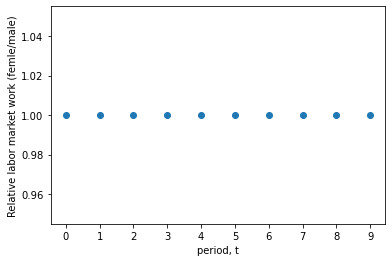

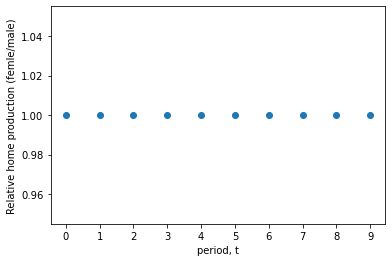

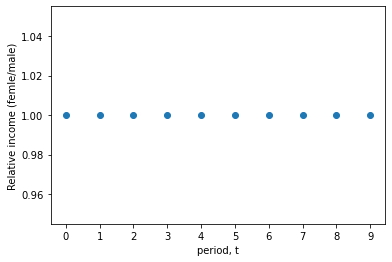

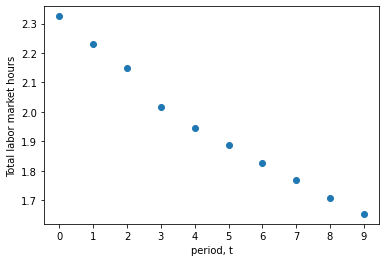

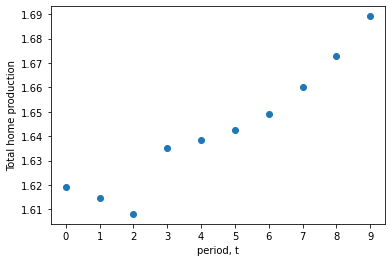

In [39]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),rel_l,label='Simulated')
ax.set(xlabel='period, t',ylabel='Relative labor market work (femle/male)',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),rel_h,label='Simulated')
ax.set(xlabel='period, t',ylabel='Relative home production (femle/male)',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),rel_in,label='Simulated')
ax.set(xlabel='period, t',ylabel='Relative income (femle/male)',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),total_l,label='Simulated')
ax.set(xlabel='period, t',ylabel='Total labor market hours',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),total_h,label='Simulated')
ax.set(xlabel='period, t',ylabel='Total home production',xticks=range(par.simT));

When men and women are initiated with the same level of human capital and have the same preferences for consumption and house production, they work an equal amount of hours on the labor market and in the home. Their incomes are therefore also the same. 

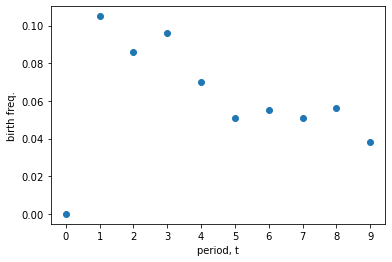

In [40]:
# birth
birth = np.zeros(model1.sim.n.shape,dtype=np.int_)
birth[:,1:] = (model1.sim.n[:,1:] - model1.sim.n[:,:-1]) > 0
fig, ax = plt.subplots()
ax.scatter(range(model1.par.simT),np.mean(birth,axis=0))
ax.set(xlabel='period, t',ylabel=f'birth freq.',xticks=range(model1.par.simT));

Children arrive stochastically with an arrival probability of 10 pct. Agents can only have one child. The figure above shows average number of children pr. period. Agents cannot have any children before period 1. Afterwards, average number of births per period decrease - namely because they can only have one child over the life cycle. 

In [41]:
# time since birth
periods = np.tile([t for t in range(model1.par.simT)],(model.par.simN,1))
time_of_birth = np.max(periods * birth, axis=1)

I = time_of_birth>0
time_of_birth[~I] = -1000 # never as a child
time_of_birth = np.transpose(np.tile(time_of_birth , (model1.par.simT,1)))

time_since_birth = periods - time_of_birth

In [42]:
# calculate average outcome across time since birth
min_time = -8
max_time = 8
event_grid = np.arange(min_time,max_time+1)

In [43]:
event_hours_l_1 = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_l_1[t] = np.mean(model1.sim.l1[time_since_birth==time])

event_hours_l_2 = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_l_2[t] = np.mean(model1.sim.l2[time_since_birth==time])

# relative to period before birth
event_hours_rel_l_1 = event_hours_l_1 - event_hours_l_1[event_grid==-1]
event_hours_rel_l_2 = event_hours_l_2 - event_hours_l_2[event_grid==-1]

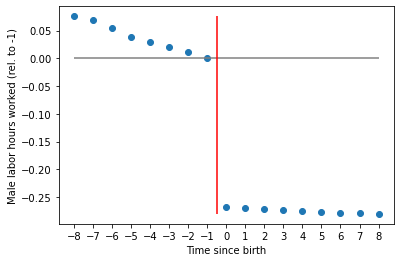

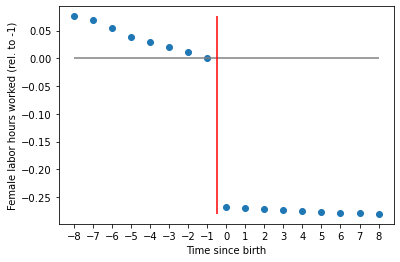

In [44]:
fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel_l_1)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel_l_1),ymax=np.nanmax(event_hours_rel_l_1),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Male labor hours worked (rel. to -1)',xticks=event_grid);

fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel_l_2)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel_l_2),ymax=np.nanmax(event_hours_rel_l_2),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Female labor hours worked (rel. to -1)',xticks=event_grid);

In the time up to a birth, both men and women are decreasing their labor supply. This is because the income effect is dominating - because wages are endogenous, agents earn more income each period because they accumulate human capital. This in turn induces them to reduce their labor supply through the income effect. After having a child, both men and women decrease their labor supply an equal amount. This is because they get equal amount of extra disutility from working when having children. 

In [45]:
event_hours_h_1 = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_h_1[t] = np.mean(model1.sim.h1[time_since_birth==time])

event_hours_h_2 = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_h_2[t] = np.mean(model1.sim.h2[time_since_birth==time])

# relative to period before birth
event_hours_rel_h_1 = event_hours_h_1 - event_hours_h_1[event_grid==-1]
event_hours_rel_h_2 = event_hours_h_2 - event_hours_h_2[event_grid==-1]

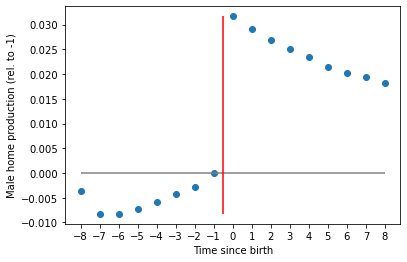

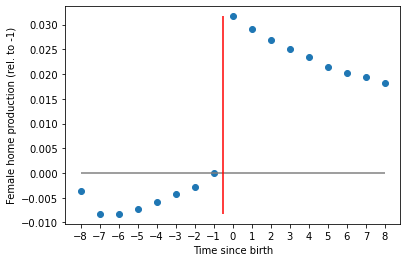

In [46]:
# plot home production relative to period before birth
fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel_h_1)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel_h_1),ymax=np.nanmax(event_hours_rel_h_1),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Male home production (rel. to -1)',xticks=event_grid);

fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel_h_2)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel_h_2),ymax=np.nanmax(event_hours_rel_h_2),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Female home production (rel. to -1)',xticks=event_grid);

In the time up to a birth, both men and women are increasing their hours spent in the home and thereby home production. This is because as wages go up, agents can work less and still satisfy the same amount of consumption and at the same time achieve more utility from home production. When children arrive, both men and women increase home production because they get an extra amount of utility from working in the home when children are present. Moreover, they also get an extra amount of disutility from working on the labor market when having kids. The effects are the same for men and women when their initial human capital are the same, when their return to human capital are the same and when preferences are the same. 

In [47]:
event_i_1 = np.nan + np.zeros(event_grid.size)
for t, time in enumerate(event_grid):
    event_i_1[t] = np.mean(model1.sim.income1[time_since_birth==time])

event_i_2 = np.nan + np.zeros(event_grid.size)
for t, time in enumerate(event_grid):
    event_i_2[t] = np.mean(model1.sim.income2[time_since_birth==time])

# relative to period before birth
event_rel_i_1 = event_i_1 - event_i_1[event_grid==-1]
event_rel_i_2 = event_i_2 - event_i_2[event_grid==-1]

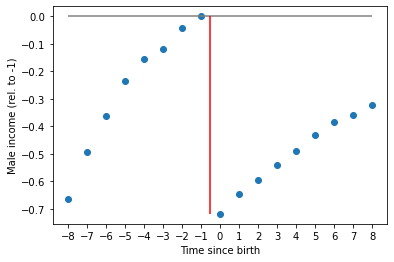

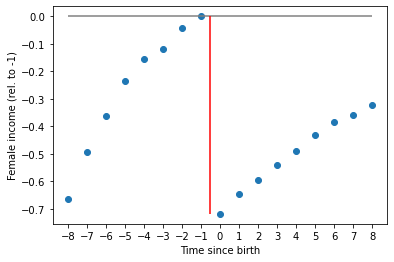

In [48]:
fig, ax = plt.subplots()
ax.scatter(event_grid,event_rel_i_1)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_rel_i_1),ymax=np.nanmax(event_rel_i_1),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Male income (rel. to -1)',xticks=event_grid);

fig, ax = plt.subplots()
ax.scatter(event_grid,event_rel_i_2)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_rel_i_2),ymax=np.nanmax(event_rel_i_2),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Female income (rel. to -1)',xticks=event_grid);

All of the above mechanisms results in lower income for both men and women around the time of birth of their child. 

# Part 2: Different levels of initial human capital 

In [49]:
model2 = model.copy()

In [50]:
model2.sim.k1_init = 6*np.ones(par.simN)
model2.simulate()

In [51]:
# Male to female ratio of labor hours and home production
rel_l = np.round(np.mean(getattr(model2.sim,'l2'),axis=0) / np.mean(getattr(model2.sim,'l1'),axis=0), 1)
rel_h = np.round(np.mean(getattr(model2.sim,'h2'),axis=0) / np.mean(getattr(model2.sim,'h1'),axis=0), 1)
rel_in = np.round(np.mean(getattr(model2.sim,'income2'),axis=0) / np.mean(getattr(model2.sim,'income1'),axis=0), 1)

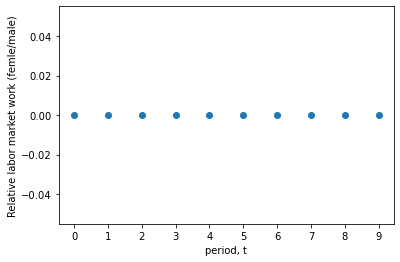

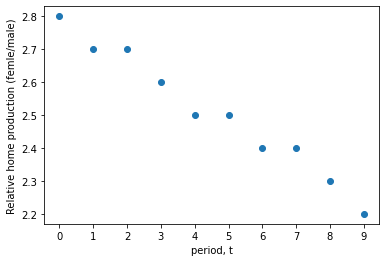

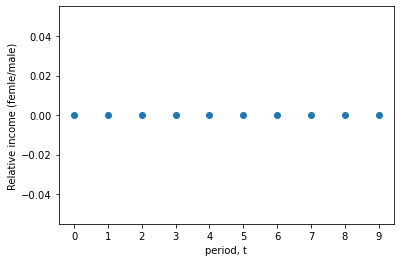

In [52]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),rel_l,label='Simulated')
ax.set(xlabel='period, t',ylabel='Relative labor market work (femle/male)',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),rel_h,label='Simulated')
ax.set(xlabel='period, t',ylabel='Relative home production (femle/male)',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),rel_in,label='Simulated')
ax.set(xlabel='period, t',ylabel='Relative income (femle/male)',xticks=range(par.simT));

When the male agent is intialized with a substantial amount of human capital, he will dedicate all of his time for labor market work whereas the female agent will dedicate all of her time to home production. In such a model, the child penalty is non-relevant as the women is already away from the labor market before having children. 

# Part 3: Incorperating unequal norms

We try to mirror the evidence of the child penalties from Kleven et. al (2019) by incorperating unequal gender norms in household decisions in regards to children. 

We do this by defining a parameter par.norms, which is set to 1 in our baseline model. In this new model, we set it to 0. 

When par.norms = 0, men do not get any extra utility from home production after having children - in stead, they get an additional amount of disutility from home production when having children. In addition, they do not get any disutility from labor market work after having children. We also add a depreciation rate in women's return to human capital par.delta2==0.2. This is based on an assumption that when females substitute towards home production in stead of labor market work, her returns to labor market work will generally become lower because she focuses more on child care and home production even when she is working. 

In [53]:
model3 = model.copy(par={'norms': 0.,'delta2':0.2})

In [54]:
model3.solve()

In [55]:
model3.simulate()

In [56]:
# Male to female ratio of labor hours and home production
rel_l = np.round(np.mean(getattr(model3.sim,'l2'),axis=0) / np.mean(getattr(model3.sim,'l1'),axis=0), 3)
rel_h = np.round(np.mean(getattr(model3.sim,'h2'),axis=0) / np.mean(getattr(model3.sim,'h1'),axis=0), 3)
rel_in = np.round(np.mean(getattr(model3.sim,'income2'),axis=0) / np.mean(getattr(model3.sim,'income1'),axis=0), 3)

In [57]:
total_l = np.mean(getattr(model3.sim,'l1') + getattr(model3.sim,'l2'),axis=0)
print(total_l)
total_h = np.mean(getattr(model3.sim,'h1') + getattr(model3.sim,'h2'),axis=0)
print(total_h)

[2.31710331 2.23070993 2.13897344 2.02787153 1.95235859 1.88926137
 1.81459972 1.739689   1.65740142 1.57106683]
[1.62446384 1.62842501 1.64131535 1.66927991 1.68470129 1.69977565
 1.7258767  1.75638773 1.79543507 1.84435493]


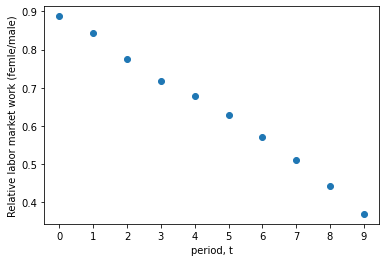

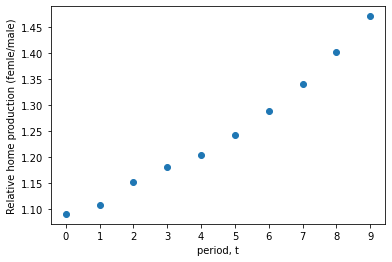

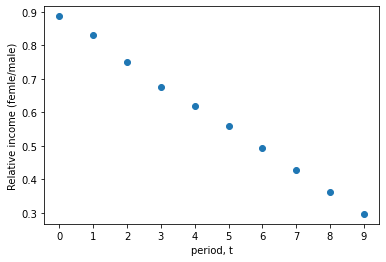

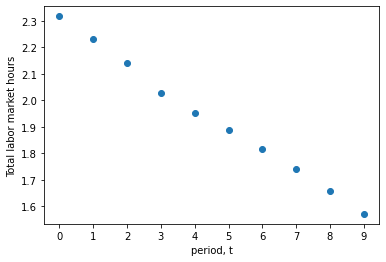

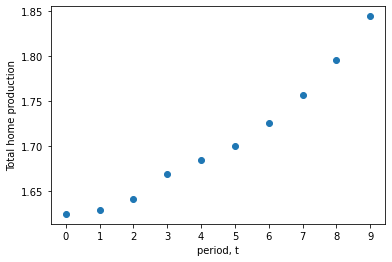

In [58]:
fig, ax = plt.subplots()
ax.scatter(range(par.simT),rel_l,label='Simulated')
ax.set(xlabel='period, t',ylabel='Relative labor market work (femle/male)',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),rel_h,label='Simulated')
ax.set(xlabel='period, t',ylabel='Relative home production (femle/male)',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),rel_in,label='Simulated')
ax.set(xlabel='period, t',ylabel='Relative income (femle/male)',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),total_l,label='Simulated')
ax.set(xlabel='period, t',ylabel='Total labor market hours',xticks=range(par.simT));

fig, ax = plt.subplots()
ax.scatter(range(par.simT),total_h,label='Simulated')
ax.set(xlabel='period, t',ylabel='Total home production',xticks=range(par.simT));

Females reduce their labor market supply over the life cycle relative to their husbands and increase home production in the new model. This leads to a fall in relative income. The effects are entirely driven by the norm effects described above as men and women are initiated with the same level of human capital, they have the same productivity in house production and when male and female house production are substitutes. 

In [59]:
# time since birth
periods = np.tile([t for t in range(model3.par.simT)],(model.par.simN,1))
time_of_birth = np.max(periods * birth, axis=1)

I = time_of_birth>0
time_of_birth[~I] = -1000 # never as a child
time_of_birth = np.transpose(np.tile(time_of_birth , (model3.par.simT,1)))

time_since_birth = periods - time_of_birth

In [60]:
# calculate average outcome across time since birth
min_time = -8
max_time = 8
event_grid = np.arange(min_time,max_time+1)

In [61]:
event_hours_l_1_n = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_l_1_n[t] = np.mean(model3.sim.l1[time_since_birth==time])

event_hours_l_2_n = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_l_2_n[t] = np.mean(model3.sim.l2[time_since_birth==time])

# relative to period before birth
event_hours_rel_l_1_n = event_hours_l_1_n - event_hours_l_1_n[event_grid==-1]
event_hours_rel_l_2_n = event_hours_l_2_n - event_hours_l_2_n[event_grid==-1]

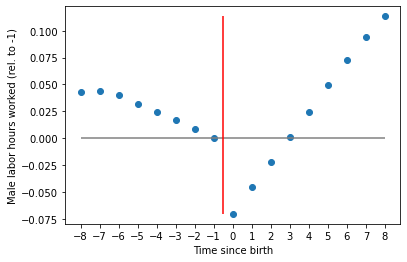

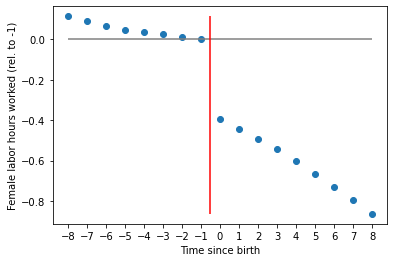

In [62]:
fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel_l_1_n)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel_l_1_n),ymax=np.nanmax(event_hours_rel_l_1_n),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Male labor hours worked (rel. to -1)',xticks=event_grid);

fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel_l_2_n)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel_l_2_n),ymax=np.nanmax(event_hours_rel_l_2_n),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Female labor hours worked (rel. to -1)',xticks=event_grid);

In the time up to having a child, both men and women reduce their labor market supply due to the income effect. At the time of birth, there is a large drop in female labor supply which continues to decrease through the life cycle. Men also reduce their labor supply but increase it again in all periods after birth. 

In [63]:
event_hours_h_1_n = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_h_1_n[t] = np.mean(model3.sim.h1[time_since_birth==time])

event_hours_h_2_n = np.nan + np.zeros(event_grid.size)
for t,time in enumerate(event_grid):
    event_hours_h_2_n[t] = np.mean(model3.sim.h2[time_since_birth==time])

# relative to period before birth
event_hours_rel_h_1_n = event_hours_h_1_n - event_hours_h_1_n[event_grid==-1]
event_hours_rel_h_2_n = event_hours_h_2_n - event_hours_h_2_n[event_grid==-1]

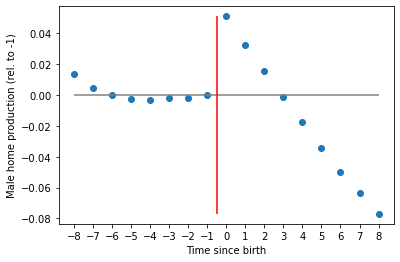

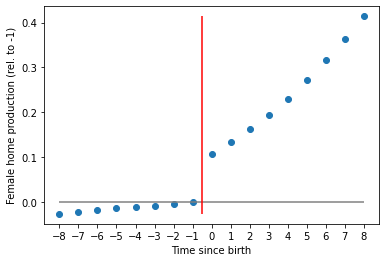

In [64]:
fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel_h_1_n)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel_h_1_n),ymax=np.nanmax(event_hours_rel_h_1_n),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Male home production (rel. to -1)',xticks=event_grid);

fig, ax = plt.subplots()
ax.scatter(event_grid,event_hours_rel_h_2_n)
ax.hlines(y=0,xmin=event_grid[0],xmax=event_grid[-1],color='gray')
ax.vlines(x=-0.5,ymin=np.nanmin(event_hours_rel_h_2_n),ymax=np.nanmax(event_hours_rel_h_2_n),color='red')
ax.set(xlabel='Time since birth',ylabel=f'Female home production (rel. to -1)',xticks=event_grid);

After having children, females get extra utility from working more hours in the home. The home production function is cobb dogulas $H=H_{M}^{1-\alpha}H_{F}^{\alpha}$, which implies that there is increasing returns to male home production - i.e. the FOC is $\frac{\partial H}{\partial H_{F}}=\alpha(\frac{H_{1}}{H_{2}})^{1-\alpha}$. Therefore, as female home production goes up, the male agent can produce more in the home for fewer hours compared to what he can bring home of consumption from working in the labor market. This explains why male labor hours $L_{M}$ decreases around child birth.This explains why the male home production $L_{M}$ and $H_{M}$ respectively increases and decreases, initially after child birth.

However, in the following periods after child birth, the man will again increase his labor supply and decrease home production. Oppositely, females reduce their labor supply and increse hours spent working in the home. This is namely due to the utility effects that make women better off working in the home and men better off working in the labor market. It also due to the increasing returns to human capital and thereby wages that women may expect after child birth that intuitively can be interpreted as a direct result of the utility effect. After having children, the man thus become responsible for providing the household with consumption and the women becomes responsible for household production, including child care. 